In [52]:
import os

DATASET = 'C:/Users/kaiqu/dog-or-cat/dataset/catbreed'

CLASSES = sorted([b for b in os.listdir(DATASET) if os.path.isdir(os.path.join(DATASET, b))])
print(f'Número de raças: {len(CLASSES)}')
print(f'Raças: {CLASSES}')

Número de raças: 24
Raças: ['Abyssinian cat', 'American Shorthair cat', 'Bengal cat', 'Birman cat', 'British Shorthair cat', 'Burmese cat', 'Calico', 'Chartreux cat', 'Cornish Rex cat', 'Devon Rex cat', 'Domestic Medium Hair', 'Egyptian Mau cat', 'Japanese Bobtail cat', 'Maine Coon cat', 'Munchkin cat', 'Ocicat cat', 'Persian cat', 'Russian Blue cat', 'Scottish Fold cat', 'Siamese cat', 'Sphynx cat', 'Turkish Angora cat', 'Turkish Van cat', 'Tuxedo']


In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split

def criar_dataframe(base_dir, test_size):
    files = []

    # coleta as imagens e suas classes
    for breed in CLASSES:
        breed_dir = os.path.join(base_dir, breed)
        if not os.path.isdir(breed_dir):
            continue

        # obtém as imagens por raça e sua quantidade
        images = [f for f in os.listdir(breed_dir) if f.endswith(('.jpg', 'png', 'jpeg', 'webp'))]
        print(f'Número de imagens da raça {breed}: {len(images)}')

        # adiciona as imagens para o files
        for img in images:
            files.append({
                'filename': os.path.join(breed_dir, img),
                'class': breed
            })

    # criar o dataframe, cada linha representa uma imagem
    files_df = pd.DataFrame(files)
    print(f'Total de imagens no dataset: {len(files_df)}')

    # dividir o dataframe em treino e teste
    train_df, test_df = train_test_split(
        files_df,
        test_size=test_size,
        stratify=files_df['class'],
        random_state=42
        )

    print(f"Divisão virtual dos dados (sem mover arquivos):")
    print(f"- {len(train_df)} imagens ({(1-test_size)*100:.0f}%) para treino")
    print(f"- {len(test_df)} imagens ({test_size*100:.0f}%) para teste")

    # codificação one-hot-encoded para as classes
    train_df = pd.get_dummies(train_df, columns=['class'])
    test_df = pd.get_dummies(test_df, columns=['class'])

    return train_df, test_df

In [54]:
# criar dataframes de treino e teste
train_df, test_df = criar_dataframe(DATASET, 0.2)

print(f"Número de imagens para treino: {len(train_df)}")
print(f"Média de imagens para treino classe: {train_df.iloc[:, 1:].sum(axis=0).mean():.2f}")
print(f"Número de imagens para teste: {len(test_df)}")
print(f"Média de imagens para teste classe: {test_df.iloc[:, 1:].sum(axis=0).mean():.2f}")

Número de imagens da raça Abyssinian cat: 572
Número de imagens da raça American Shorthair cat: 427
Número de imagens da raça Bengal cat: 533
Número de imagens da raça Birman cat: 540
Número de imagens da raça British Shorthair cat: 530
Número de imagens da raça Burmese cat: 522
Número de imagens da raça Calico: 569
Número de imagens da raça Chartreux cat: 330
Número de imagens da raça Cornish Rex cat: 309
Número de imagens da raça Devon Rex cat: 446
Número de imagens da raça Domestic Medium Hair: 471
Número de imagens da raça Egyptian Mau cat: 426
Número de imagens da raça Japanese Bobtail cat: 462
Número de imagens da raça Maine Coon cat: 537
Número de imagens da raça Munchkin cat: 488
Número de imagens da raça Ocicat cat: 375
Número de imagens da raça Persian cat: 608
Número de imagens da raça Russian Blue cat: 553
Número de imagens da raça Scottish Fold cat: 400
Número de imagens da raça Siamese cat: 537
Número de imagens da raça Sphynx cat: 411
Número de imagens da raça Turkish An

Exemplos de Abyssinian cat:


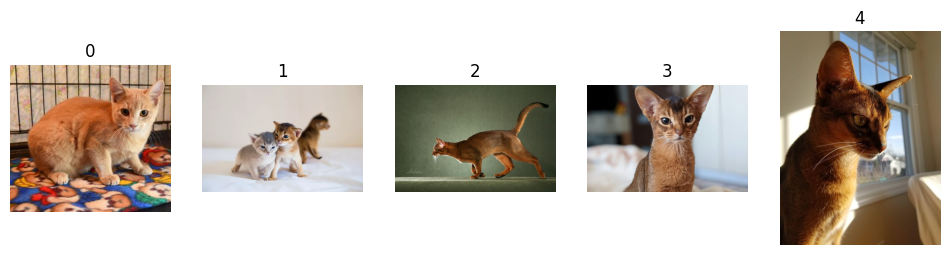

Exemplos de American Shorthair cat:


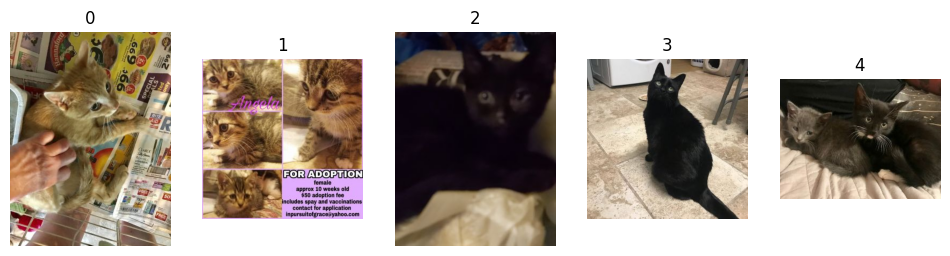

Exemplos de Bengal cat:


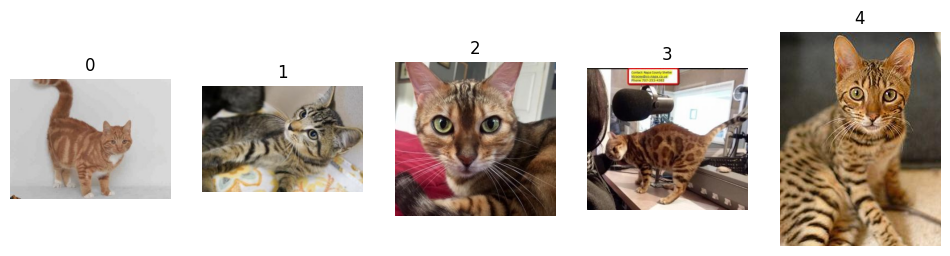

Exemplos de Birman cat:


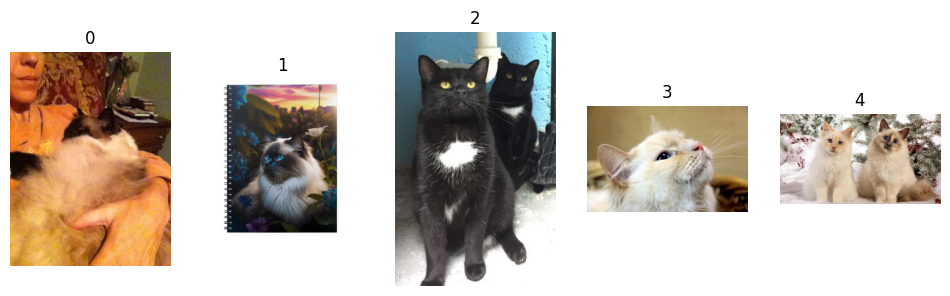

Exemplos de British Shorthair cat:


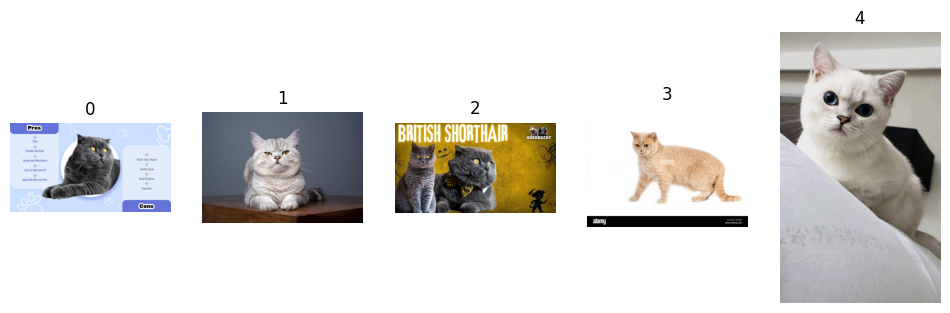

In [55]:
import matplotlib.pyplot as plt
import cv2

def grid_exemplo(dataframe, classe, num_exemplos):
    col_classe = f'class_{classe}'
    if col_classe not in dataframe.columns:
        print(f'Classe {classe} não encontrada no dataframe.')
        return

    # filtra o dataframe pela classe
    df_classe = dataframe[dataframe[col_classe] == 1]['filename'].tolist()[:num_exemplos]

    # plota os exemplos
    plt.figure(figsize=(12, 4))
    for i, img_dir in enumerate(df_classe):
        img = cv2.imread(img_dir)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_exemplos, i + 1)
        plt.imshow(img)
        plt.title(f'{i}')
        plt.axis('off')
    plt.show()

for classe in CLASSES[:5]:
    print(f"Exemplos de {classe}:")
    grid_exemplo(train_df, classe, 5)

In [56]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B3
import logging

IMG_SIZE = 224

def load_preprocess_image(file):
    """
    Load and preprocess an image for EfficientNet.

    Parameters:
        file (str): The file path to the image.

    Returns:
        img (np.array): The preprocessed image ready for the model.
    """
    # Check that the file exists
    if not os.path.exists(file):
        raise FileNotFoundError(f"File {file} does not exist.")

    # Load the image using OpenCV
    img = cv2.imread(file)

    # Validate that the image was loaded successfully
    if img is None:
        raise ValueError(f"Image at path {file} could not be loaded. Check the file format or file integrity.")

    # Convert BGR (OpenCV default) to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image to match the target dimensions
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Preprocess the image input for EfficientNet
    # Consider using efficientnet_v2.preprocess_input if you're working with EfficientNetV2 models.
    img = tf.keras.applications.efficientnet.preprocess_input(img)

    return img

In [57]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class DataFrameGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, x_col, y_cols, batch_size,
                 img_size = (IMG_SIZE, IMG_SIZE), shuffle=True, augment = True):
        self.df = dataframe.copy()
        self.x_col = x_col
        self.y_cols = y_cols
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.n = len(self.df)
        self.indices = np.arange(self.n)
        self.datagen = None

        # augmentação de dados
        if self.augment:
            self.datagen = ImageDataGenerator(
                rotation_range=30,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                brightness_range=[0.8, 1.2],
                fill_mode='nearest'
            )

        self.on_epoch_end()

        # obtemos os nomes das classes do one hot encoding
        self.class_indices = {}
        for i, col in enumerate([c for c in self.df.columns if c.startswith('class_')]):
            self.class_indices[col.replace('class_', '')] = i # troca o class_ pelo nome da classe (i)
        self.classes = np.argmax(self.df[self.y_cols].values, axis = 1)

    def __len__(self):
        return int(np.ceil(self.n / self.batch_size))

    def __getitem__(self, index):
        batch_index = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_x = np.array([load_preprocess_image(file) for file in self.df.iloc[batch_index][self.x_col]])
        batch_y = self.df.iloc[batch_index][self.y_cols].values

        if self.augment:
            batch_x = np.array([self.datagen.random_transform(img) for img in batch_x])

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def reset(self):
        self.on_epoch_end()

In [58]:
y_cols = [col for col in train_df.columns if col.startswith('class_')]

train_df_final, val_df_final = train_test_split(
    train_df,
    test_size = 0.2,
    stratify = np.argmax(train_df[y_cols].values, axis = 1),
    random_state = 42
)

In [59]:
train_generator = DataFrameGenerator(
    train_df_final,
    'filename',
    y_cols,
    batch_size = 32,
    img_size = (IMG_SIZE, IMG_SIZE),
    shuffle = True,
    augment = True
)

val_generator = DataFrameGenerator(
    val_df_final,
    'filename',
    y_cols,
    batch_size = 32,
    img_size = (IMG_SIZE, IMG_SIZE),
    shuffle = False,
    augment = False
)

test_generator = DataFrameGenerator(
    test_df,
    'filename',
    y_cols,
    batch_size = 32,
    img_size = (IMG_SIZE, IMG_SIZE),
    shuffle = False,
    augment = False
)

In [60]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-6),
    ModelCheckpoint('model_checkpoint.h5', save_best_only=True, monitor='val_loss', mode='min'),
]

In [61]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

def criar_modelo():
    base_model = EfficientNetV2B3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

    base_model.trainable = False  # Congela a base

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(len(CLASSES), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
        )

    return model, base_model

In [62]:
model, base_model = criar_modelo()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 224, 224, 3)  0          ['rescaling_3[0][0]']            
 )                                                                                                
                                                                                            

In [63]:
print(f"Número de classes no modelo: {len(y_cols)}")
print(f"Número de pastas de classes: {len(CLASSES)}")

# Treinamento inicial com o modelo base congelado
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=callbacks
)

Número de classes no modelo: 24
Número de pastas de classes: 24
Epoch 1/10
238/238 [==============================] - 113s 437ms/step - loss: 2.1452 - accuracy: 0.3552 - val_loss: 1.6712 - val_accuracy: 0.4729 - lr: 0.0010
Epoch 2/10
238/238 [==============================] - 102s 430ms/step - loss: 1.7579 - accuracy: 0.4598 - val_loss: 1.5892 - val_accuracy: 0.5150 - lr: 0.0010
Epoch 3/10
238/238 [==============================] - 96s 404ms/step - loss: 1.6265 - accuracy: 0.4993 - val_loss: 1.5354 - val_accuracy: 0.5245 - lr: 0.0010
Epoch 4/10
238/238 [==============================] - 113s 475ms/step - loss: 1.5555 - accuracy: 0.5257 - val_loss: 1.4818 - val_accuracy: 0.5477 - lr: 0.0010
Epoch 5/10
238/238 [==============================] - 108s 453ms/step - loss: 1.4772 - accuracy: 0.5439 - val_loss: 1.5193 - val_accuracy: 0.5434 - lr: 0.0010
Epoch 6/10
238/238 [==============================] - 104s 436ms/step - loss: 1.4458 - accuracy: 0.5534 - val_loss: 1.4657 - val_accuracy: 0.5

In [64]:
model_version = "catbreed_model_v5.h5"
model.save(model_version)
print(f"Modelo base salvo como {model_version}")

Modelo base salvo como catbreed_model_v5.h5


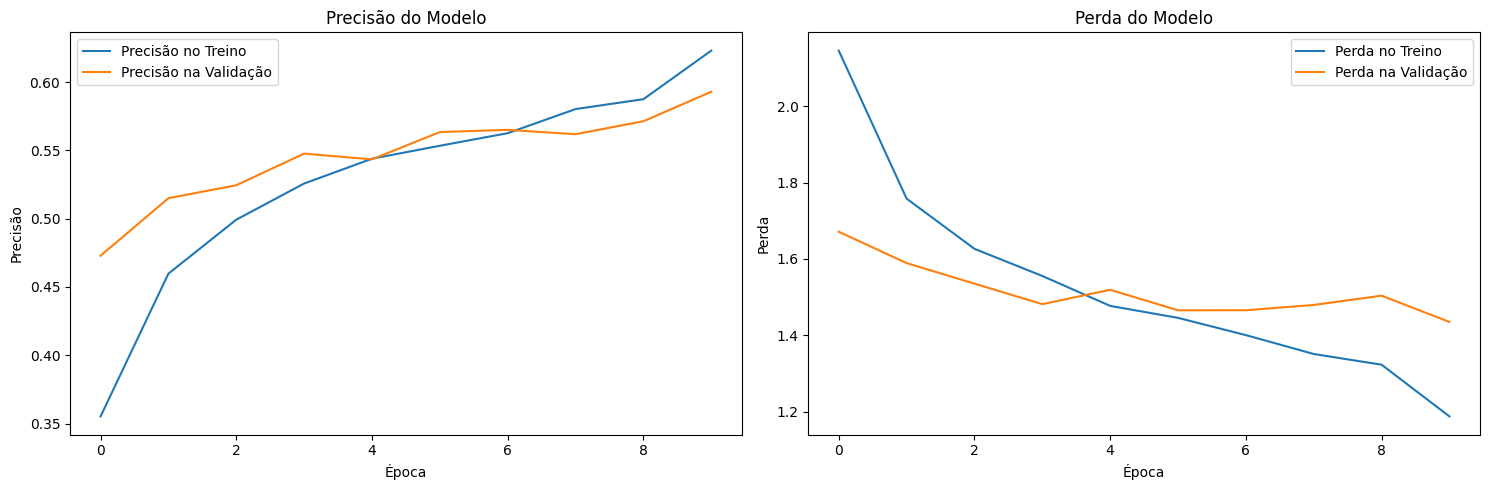

In [65]:
def plotar_historico(historico):
    """Plota o histórico de treinamento do modelo."""
    acc = historico.history['accuracy']
    val_acc = historico.history['val_accuracy']
    loss = historico.history['loss']
    val_loss = historico.history['val_loss']

    plt.figure(figsize=(15, 5))

    # Gráfico de precisão
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Precisão no Treino')
    plt.plot(val_acc, label='Precisão na Validação')
    plt.title('Precisão do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Precisão')
    plt.legend()

    # Gráfico de perda
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Perda no Treino')
    plt.plot(val_loss, label='Perda na Validação')
    plt.title('Perda do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plotar o histórico de treinamento
plotar_historico(history)

In [66]:
# Avaliar o modelo nos dados de teste
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Precisão no teste: {test_accuracy:.4f}")

75/75 [==============================] - 10s 134ms/step - loss: 1.3709 - accuracy: 0.5981
Precisão no teste: 0.5981


75/75 [==============================] - 10s 101ms/step


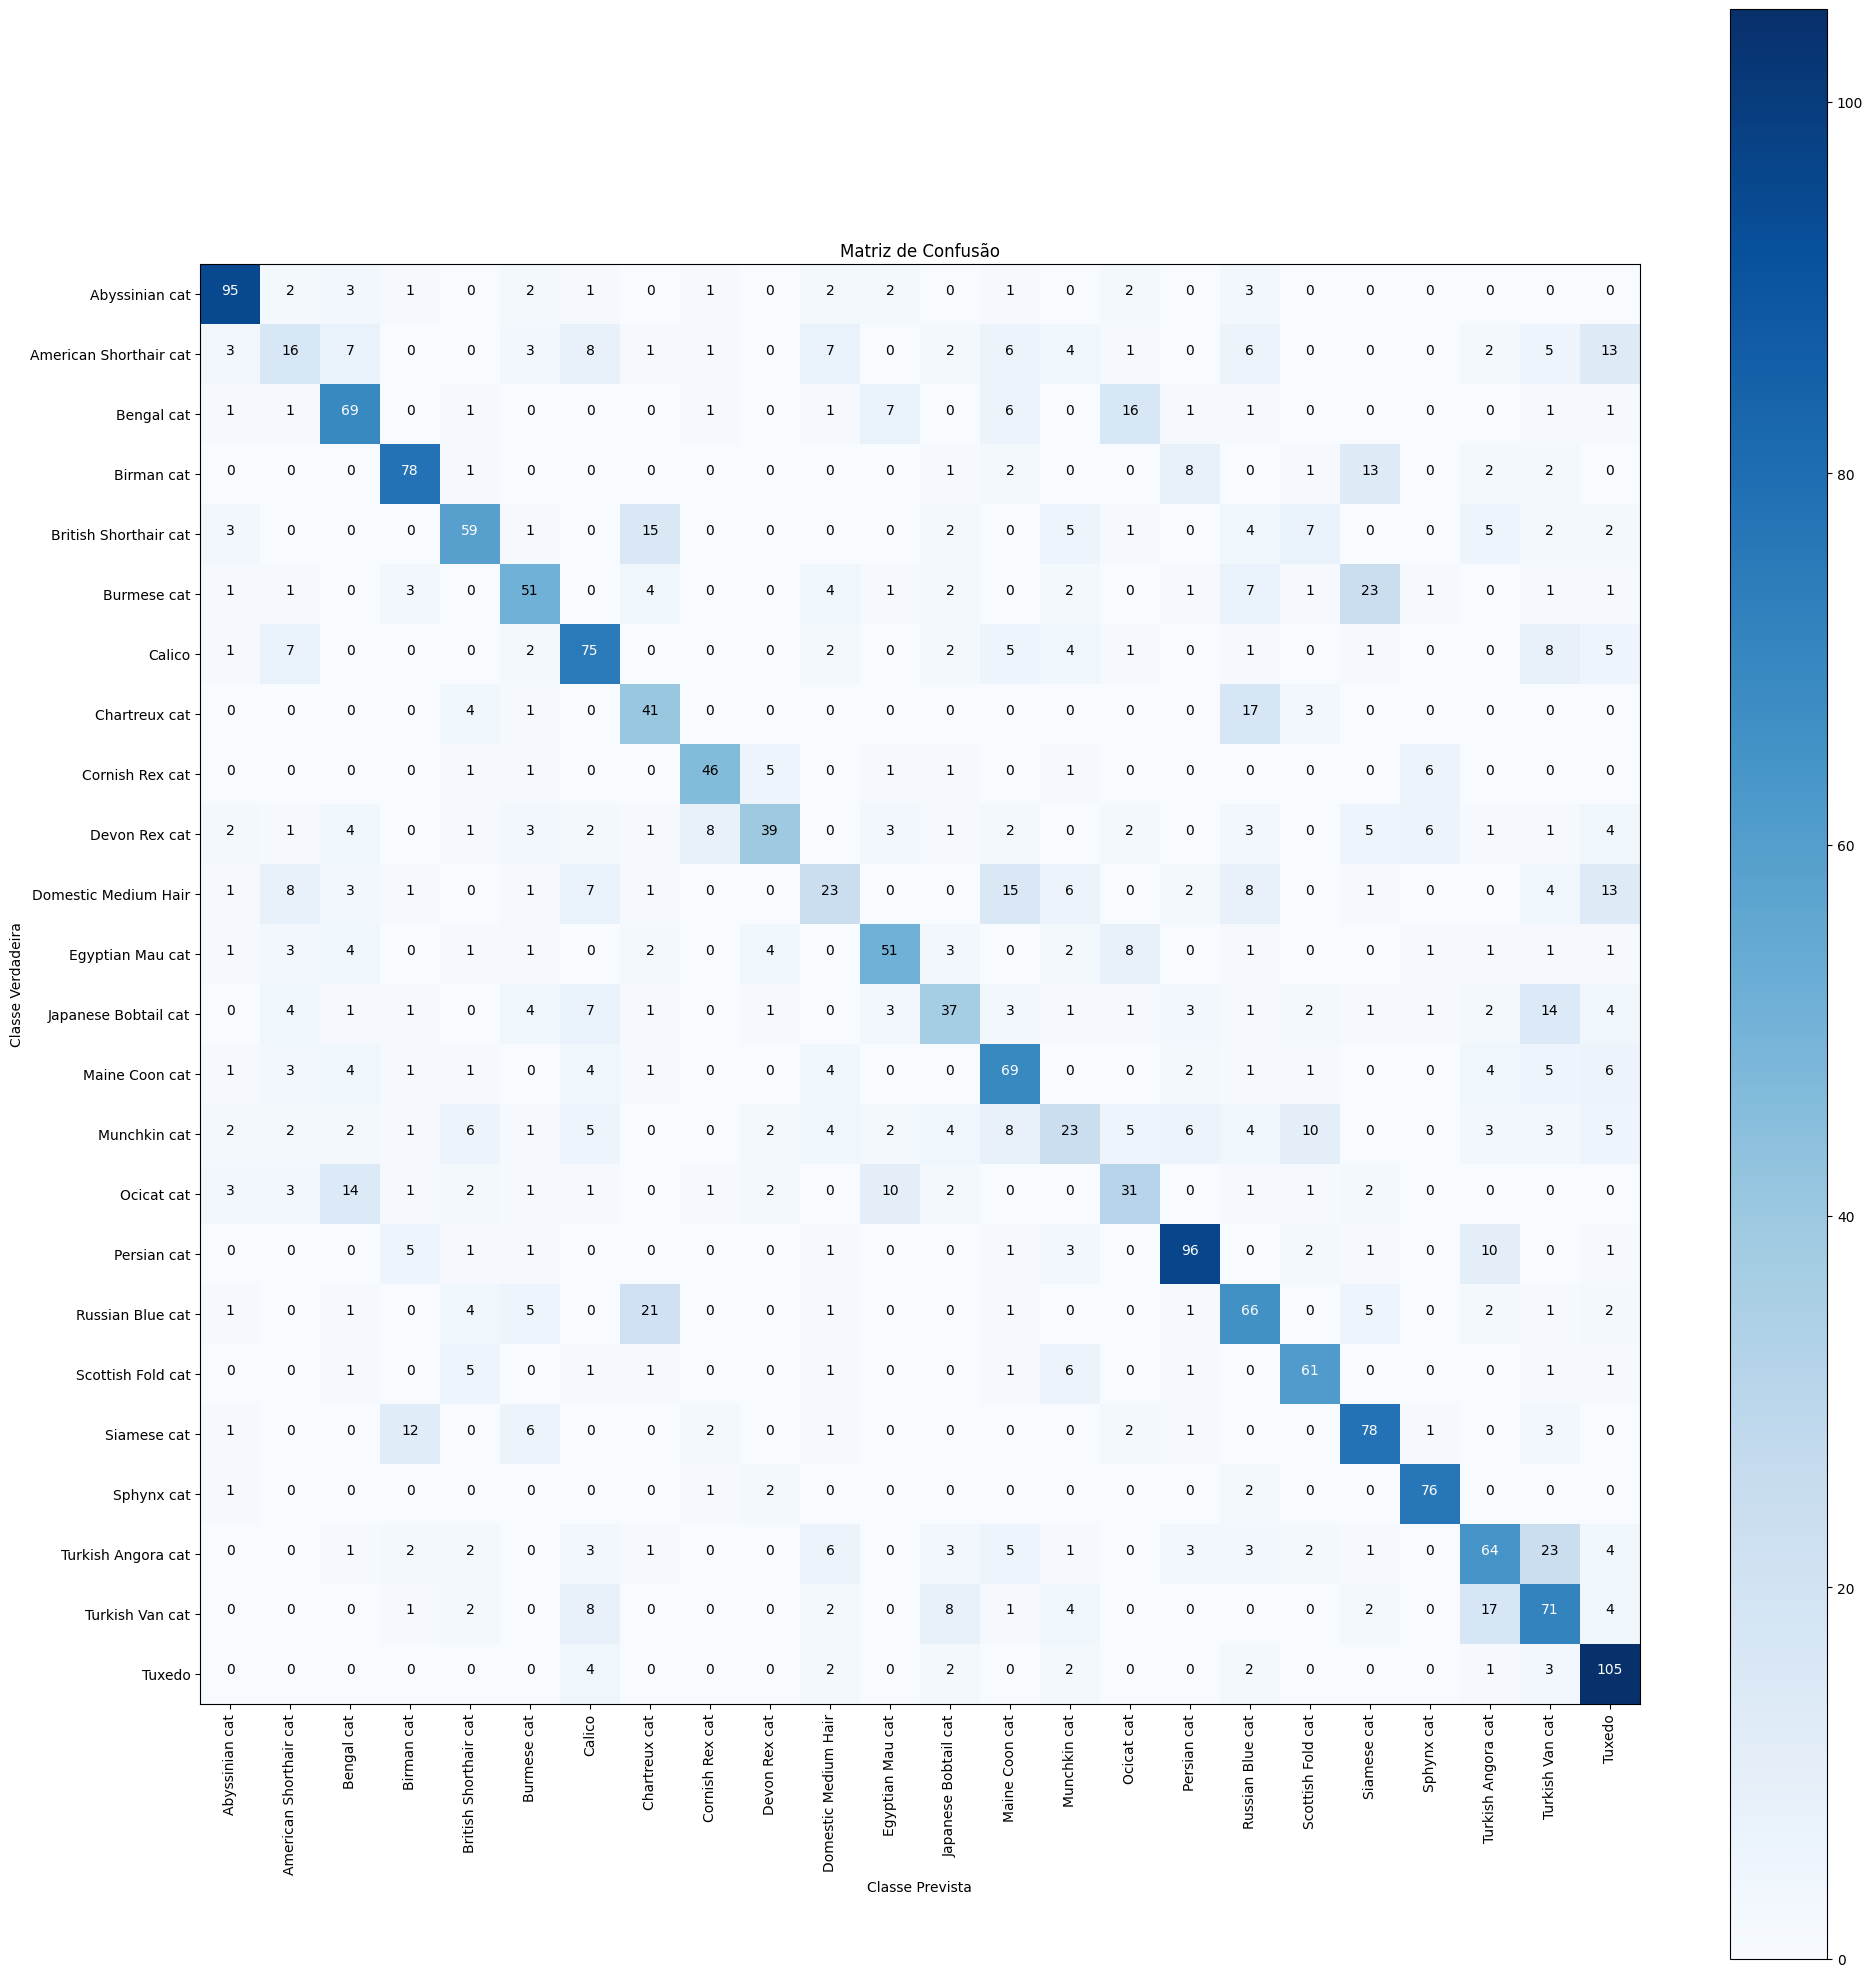

Relatório de Classificação:
                        precision    recall  f1-score   support

        Abyssinian cat       0.81      0.83      0.82       115
American Shorthair cat       0.31      0.19      0.24        85
            Bengal cat       0.61      0.64      0.62       107
            Birman cat       0.73      0.72      0.73       108
 British Shorthair cat       0.65      0.56      0.60       106
           Burmese cat       0.61      0.49      0.54       104
                Calico       0.60      0.66      0.62       114
         Chartreux cat       0.46      0.62      0.53        66
       Cornish Rex cat       0.75      0.74      0.75        62
         Devon Rex cat       0.71      0.44      0.54        89
  Domestic Medium Hair       0.38      0.24      0.30        94
      Egyptian Mau cat       0.64      0.60      0.62        85
  Japanese Bobtail cat       0.53      0.40      0.46        92
        Maine Coon cat       0.55      0.64      0.59       107
          M

In [67]:
from sklearn.metrics import classification_report, confusion_matrix

# Fazer previsões no conjunto de teste
previsoes = model.predict(test_generator)
previsoes_classes = np.argmax(previsoes, axis=1)

# Obter os rótulos verdadeiros
rotulos_verdadeiros = test_generator.classes

# Matriz de confusão
matriz_confusao = confusion_matrix(rotulos_verdadeiros, previsoes_classes)

# Criar figura da matriz de confusão
plt.figure(figsize=(20, 20))
plt.imshow(matriz_confusao, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
tick_marks = np.arange(len(CLASSES))
plt.xticks(tick_marks, CLASSES, rotation=90)
plt.yticks(tick_marks, CLASSES)

for i in range(len(CLASSES)):
    for j in range(len(CLASSES)):
        plt.text(j, i, format(matriz_confusao[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if matriz_confusao[i, j] > matriz_confusao.max() / 2 else "black")

plt.tight_layout()
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')

# Salvar a matriz de confusão como imagem
plt.savefig('confusion_matrix.png', bbox_inches='tight', dpi=300)
plt.show()

# Relatório de classificação
relatorio = classification_report(rotulos_verdadeiros, previsoes_classes, target_names=CLASSES, zero_division=0)
print("Relatório de Classificação:")
print(relatorio)

In [68]:
CLASSES = ['Abyssinian cat', 'American Shorthair cat', 'Bengal cat', 'Birman cat', 'British Shorthair cat', 'Burmese cat', 'Calico', 'Chartreux cat', 'Cornish Rex cat', 'Devon Rex cat', 'Domestic Medium Hair', 'Egyptian Mau cat', 'Japanese Bobtail cat', 'Maine Coon cat', 'Munchkin cat', 'Ocicat cat', 'Persian cat', 'Russian Blue cat', 'Scottish Fold cat', 'Siamese cat', 'Sphynx cat', 'Turkish Angora cat', 'Turkish Van cat', 'Tuxedo']

In [69]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf


def load_preprocess_image(file):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img

def test_image(file):
    model = load_model(model_version)

    img = load_preprocess_image(file)

    # Exibe a imagem
    plt.imshow(img)
    plt.title(f"Imagem Externa ({file})")
    plt.axis("off")
    plt.show()

    img_expanded = np.expand_dims(img, axis=0)

    # Realiza a predição
    previsao = model.predict(img_expanded)
    print("Predição (vetor de probabilidades):")
    # print(previsao)

    # # Ordena os índices de acordo com as probabilidades (do menor para o maior)
    indices_ordenados = np.argsort(previsao[0])
    # # Seleciona os 5 índices com maiores probabilidades e inverte a ordem (do maior para o menor)
    top5_indices = indices_ordenados[-5:][::-1]
    print("Top 5 índices:", top5_indices)

    # print("Top 5 raças mais prováveis:")
    for i in top5_indices:
        print(f"Raça: {CLASSES[i]} - Probabilidade: {(previsao[0][i]) * 100:.2f}%")

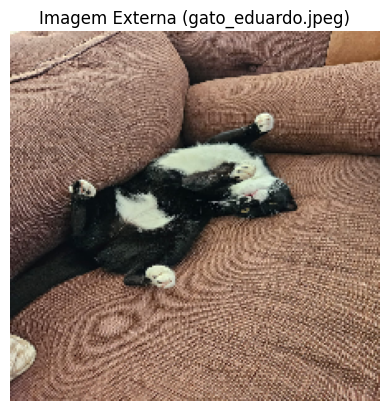

1/1 [==============================] - 4s 4s/step
Predição (vetor de probabilidades):
Top 5 índices: [23  1 10 12 14]
Raça: Tuxedo - Probabilidade: 88.49%
Raça: American Shorthair cat - Probabilidade: 8.65%
Raça: Domestic Medium Hair - Probabilidade: 1.64%
Raça: Japanese Bobtail cat - Probabilidade: 0.70%
Raça: Munchkin cat - Probabilidade: 0.21%


In [70]:
test_image('gato_eduardo.jpeg')

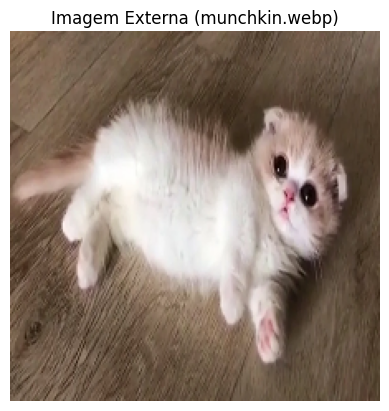

1/1 [==============================] - 3s 3s/step
Predição (vetor de probabilidades):
Top 5 índices: [14 21 16  3 22]
Raça: Munchkin cat - Probabilidade: 40.91%
Raça: Turkish Angora cat - Probabilidade: 14.92%
Raça: Persian cat - Probabilidade: 12.55%
Raça: Birman cat - Probabilidade: 12.44%
Raça: Turkish Van cat - Probabilidade: 8.22%


In [71]:
test_image('munchkin.webp')

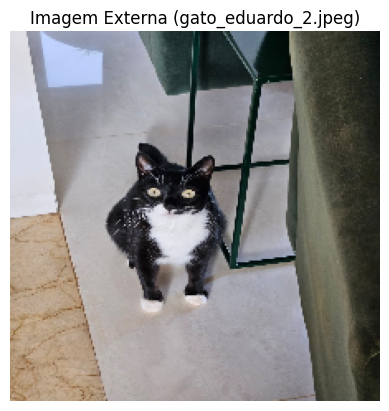

1/1 [==============================] - 2s 2s/step
Predição (vetor de probabilidades):
Top 5 índices: [ 6 12 14 23  1]
Raça: Calico - Probabilidade: 80.21%
Raça: Japanese Bobtail cat - Probabilidade: 6.14%
Raça: Munchkin cat - Probabilidade: 5.06%
Raça: Tuxedo - Probabilidade: 4.16%
Raça: American Shorthair cat - Probabilidade: 3.52%


In [72]:
test_image('gato_eduardo_2.jpeg')

In [ ]:
test_image('cuyrlyeaevue1.jpeg')